
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/EffiSciencesResearch/hackathon42/blob/main/starting_pack_hackathon42.ipynb)


In [131]:
# This can take a moment
# Please install git large file system before cloning
!git lfs install
!git clone  --depth=1  https://github.com/EffiSciencesResearch/hackathon42.git

Updated git hooks.
Git LFS initialized.
Cloning into 'hackathon42'...
remote: Enumerating objects: 141, done.
remote: Counting objects: 100% (141/141), done.
remote: Compressing objects: 100% (138/138), done.
remote: Total 141 (delta 0), reused 133 (delta 0), pack-reused 0
Receiving objects: 100% (141/141), 1.43 MiB | 11.16 MiB/s, done.
tcmalloc: large alloc 1471086592 bytes == 0x5618ce868000 @  0x7f8335efb2a4 0x561891f9511f 0x561891f7225b 0x561891f26f33 0x561891ecb22a 0x561891ecb6e6 0x561891ee8451 0x561891ee89e9 0x561891ee8f13 0x561891f8de12 0x561891e2f162 0x561891e15a65 0x561891e16725 0x561891e1572a 0x7f8335242c87 0x561891e1577a
tcmalloc: large alloc 1471086592 bytes == 0x5618ce868000 @  0x7f8335efb2a4 0x561891f9511f 0x561891f7225b 0x561891f26f33 0x561891ecb22a 0x561891ecb6e6 0x561891ee8451 0x561891ee89e9 0x561891ee8f13 0x561891f8de12 0x561891e2f162 0x561891e15a65 0x561891e16725 0x561891e1572a 0x7f8335242c87 0x561891e1577a
Filtering content: 100% (106/106), 5.37 GiB | 53.05 MiB/s, do

In [187]:
%cd /content/hackathon42/hackathon42

import numpy as np
from tqdm.notebook import tqdm
import os
from os.path import join
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F

use_cuda = False
device = torch.device("cuda" if use_cuda else "cpu")

datasets_names = sorted(os.listdir(path='datasets2'), key=lambda name: int(name[:2]))
datasets_names = {int(datasets_name.split("_")[0]): datasets_name for datasets_name in datasets_names}
print(datasets_names)

# You can choose the dataset here by modifying the brackets
dataset_name = join('datasets2', datasets_names[1])
#assert "01_mnist_cc" in dataset_name, "This colab is destined for MNIST, and not for the other datasets. The code needs to be adapted :) "
print(dataset_name)

X_labeled = np.load(join(dataset_name, "X_labeled.npy"))
y_labeled = np.load(join(dataset_name, "y_labeled.npy"))
X_unlabeled = np.load(join(dataset_name, "X_unlabeled.npy"))
X_val = np.load(join(dataset_name, "X_val.npy"))


X_train, X_test, y_train, y_test = train_test_split(X_labeled, y_labeled)


X_train = torch.tensor(X_train, device=device).float()
X_test = torch.tensor(X_test, device=device).float()
y_train = torch.tensor(y_train, device=device)
y_test = torch.tensor(y_test, device=device)

/content/hackathon42/hackathon42
{0: '00_toy_dataset', 1: '01_mnist_cc', 2: '02_mnist_constant_image', 3: '03_mnist_constant_image_random_row', 4: '04_mnist_uniform_color_random_row', 5: '05_mnist_uniform_color_low_mix_rate', 6: '06_mnist_sum', 8: '08_mnist_sum_noise_level', 12: '12_mnist_mysterious', 13: '13_mnist_mysterious', 23: '23_mnist_embed', 456: '456_mnist_embed', 888: '888_vehicle_animal', 999: '999_humans'}
datasets2/01_mnist_cc


In [201]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()

        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 400),
            nn.ReLU(),
            nn.Linear(400, 300),
            nn.ReLU(),
            nn.Linear(300, 200),
            nn.ReLU(),
            nn.Linear(200, 2),
        )

    def forward(self, x):
        logits = self.linear_relu_stack(self.flatten(x[:,:,:,:28]))
        return logits
net = NeuralNetwork().to(device)

In [202]:
import pandas as pd

tbatch = 100
nb_epochs = 20

nbbatchs = int(X_train.shape[0]/tbatch)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)

net.train()

def evaluate(X_test):
    net.eval()
    with torch.no_grad():
        y_pred = net(X_test)
    correct_test = (torch.argmax(y_pred, axis=1) == y_test).sum().item()
    net.train()
    return correct_test/len(X_test)

for epoch in tqdm(range(nb_epochs)):  # loop over the dataset multiple times
    correct = 0
    for i in (range(nbbatchs)):
        
        optimizer.zero_grad()
        
        X_batch = X_train[i*tbatch:(i+1)*tbatch]
        y_batch = y_train[i*tbatch:(i+1)*tbatch]

        # Compute forward / backward
        y_pred = net(X_batch)
        correct += (torch.argmax(y_pred, axis=1) == y_batch).sum().item()

        loss = criterion(y_pred, y_batch)
        

        loss.backward()
        optimizer.step()
        # break
    print("acc train:", correct/X_train.shape[0], "acc test:", evaluate(X_test))




  0%|          | 0/20 [00:00<?, ?it/s]

acc train: 0.6494736842105263 acc test: 0.9905362776025236
acc train: 0.9442105263157895 acc test: 0.9936908517350158
acc train: 0.9473684210526315 acc test: 0.9936908517350158
acc train: 0.9473684210526315 acc test: 0.9936908517350158
acc train: 0.9473684210526315 acc test: 0.9936908517350158
acc train: 0.9473684210526315 acc test: 0.9936908517350158
acc train: 0.9473684210526315 acc test: 0.9936908517350158
acc train: 0.9473684210526315 acc test: 0.9936908517350158
acc train: 0.9473684210526315 acc test: 0.9936908517350158
acc train: 0.9473684210526315 acc test: 0.9936908517350158
acc train: 0.9473684210526315 acc test: 0.9936908517350158
acc train: 0.9473684210526315 acc test: 0.9936908517350158
acc train: 0.9473684210526315 acc test: 0.9936908517350158
acc train: 0.9473684210526315 acc test: 0.9936908517350158
acc train: 0.9473684210526315 acc test: 0.9936908517350158
acc train: 0.9473684210526315 acc test: 0.9936908517350158
acc train: 0.9473684210526315 acc test: 0.99369085173501

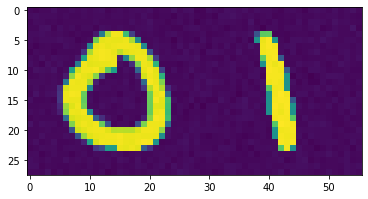

tensor(0) 0



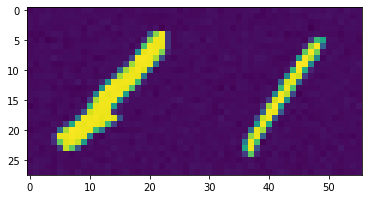

tensor(1) 1



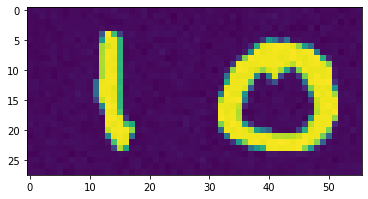

tensor(1) 2



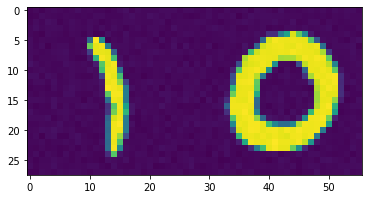

tensor(1) 3



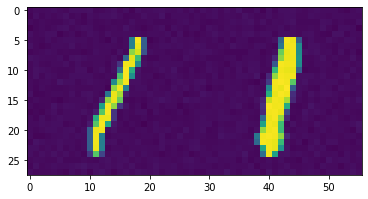

tensor(1) 4



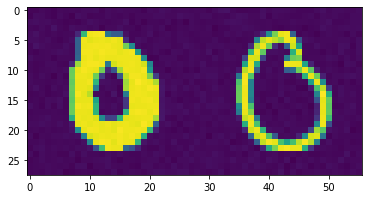

tensor(0) 5



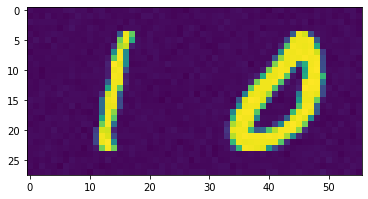

tensor(1) 6



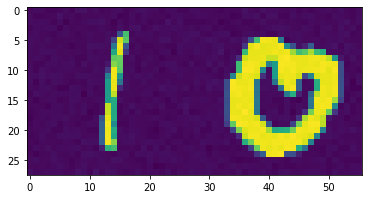

tensor(1) 7



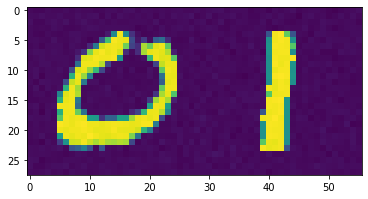

tensor(0) 8



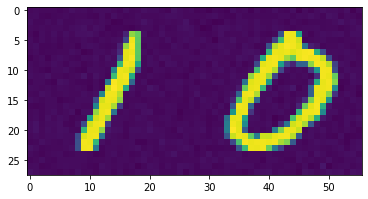

tensor(1) 9



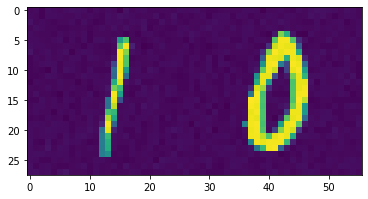

tensor(1) 10



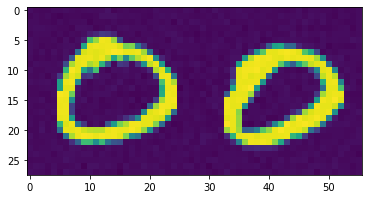

tensor(0) 11



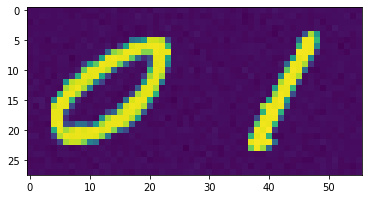

tensor(0) 12



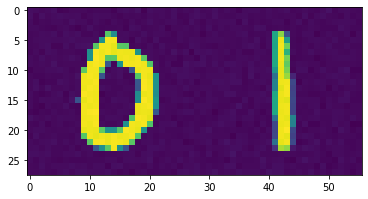

tensor(0) 13



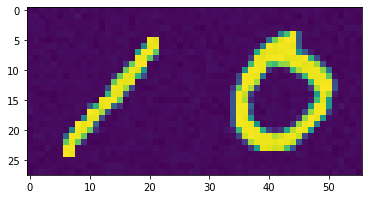

tensor(1) 14



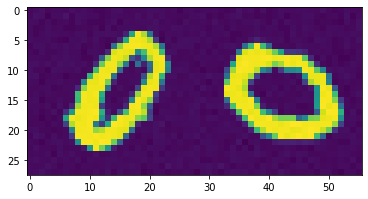

tensor(0) 15



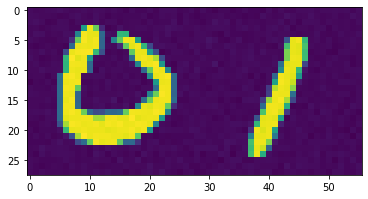

tensor(0) 16



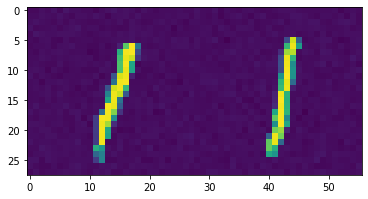

tensor(1) 17



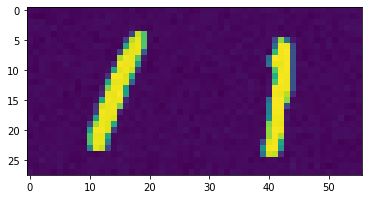

tensor(1) 18



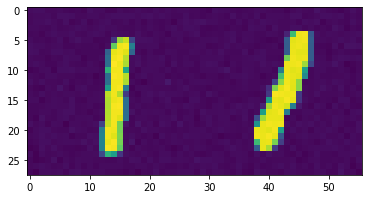

tensor(1) 19



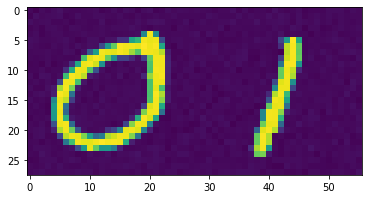

tensor(0) 20



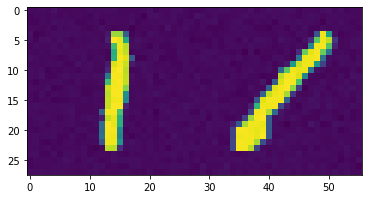

tensor(1) 21



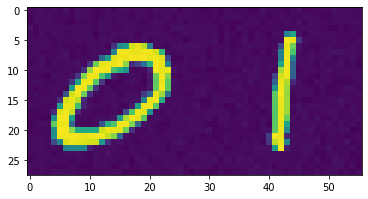

tensor(0) 22



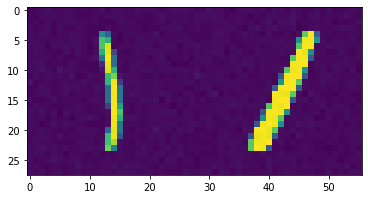

tensor(1) 23



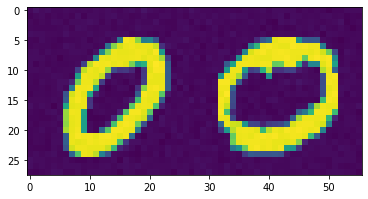

tensor(0) 24



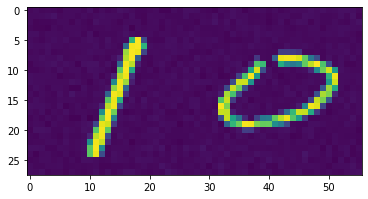

tensor(1) 25



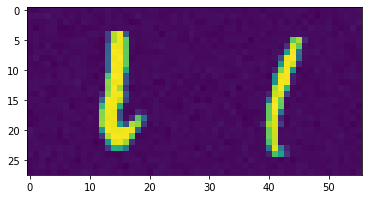

tensor(1) 26



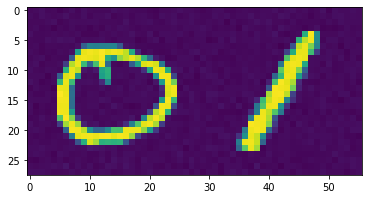

tensor(0) 27



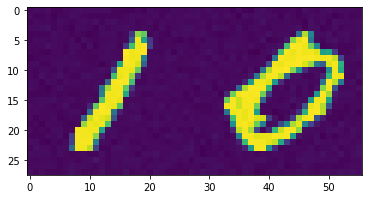

tensor(1) 28



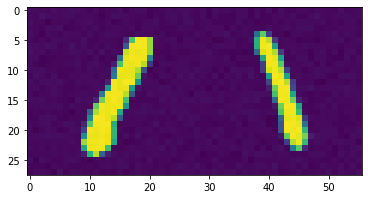

tensor(1) 29



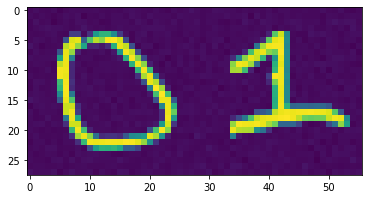

tensor(0) 30



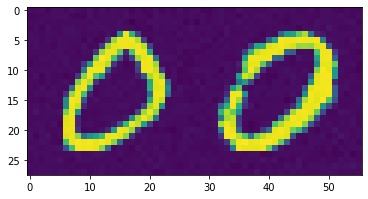

tensor(0) 31



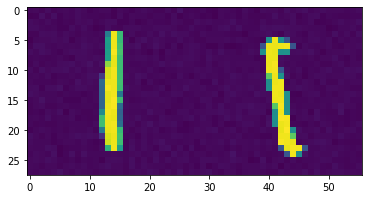

tensor(1) 32



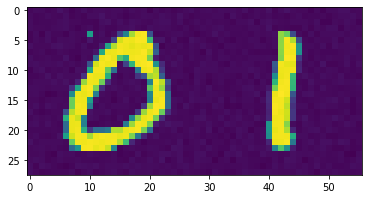

tensor(0) 33



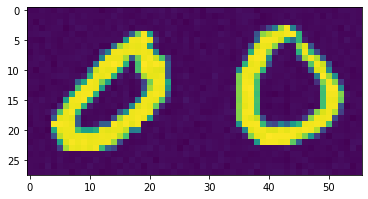

tensor(0) 34



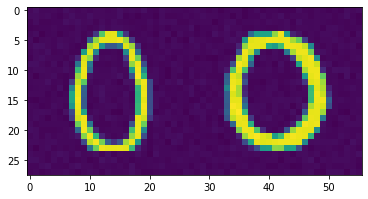

tensor(0) 35



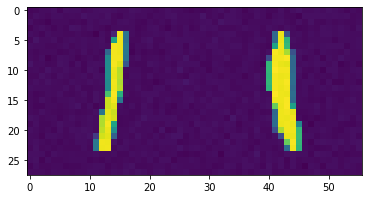

tensor(1) 36



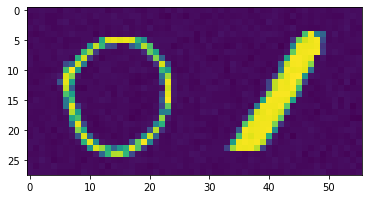

tensor(0) 37



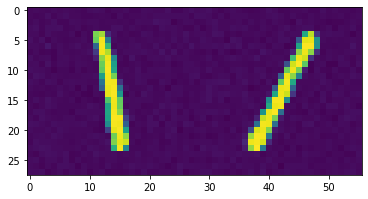

tensor(1) 38



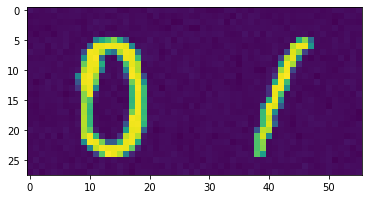

tensor(0) 39



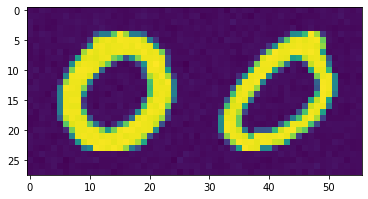

tensor(0) 40



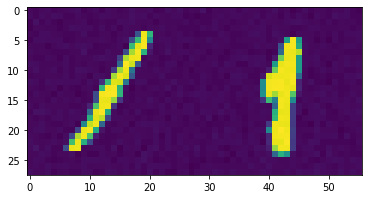

tensor(1) 41



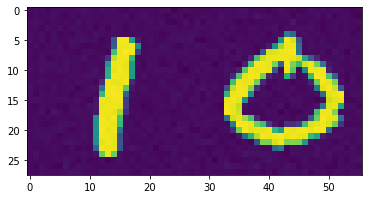

tensor(1) 42



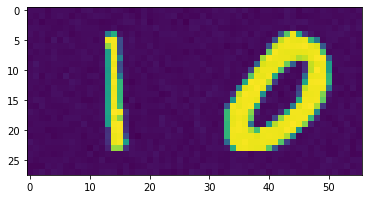

tensor(1) 43



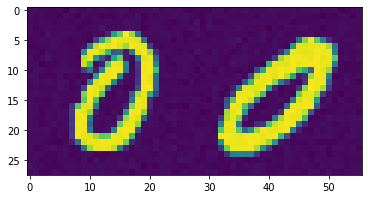

tensor(0) 44



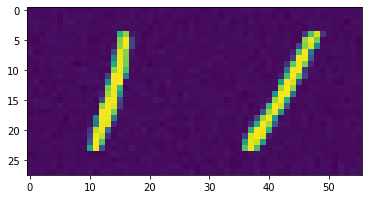

tensor(1) 45



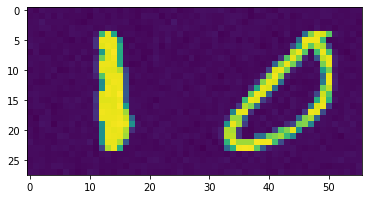

tensor(1) 46



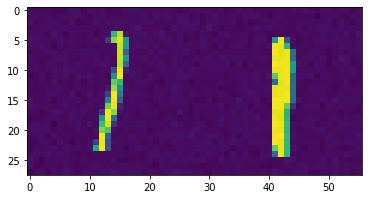

tensor(1) 47



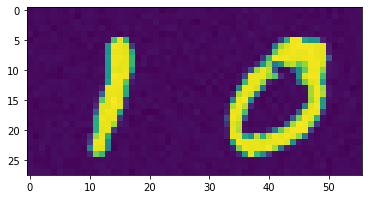

tensor(1) 48



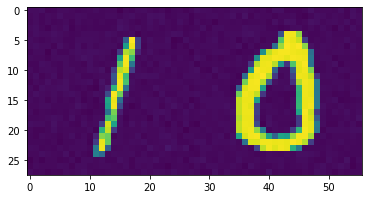

tensor(1) 49



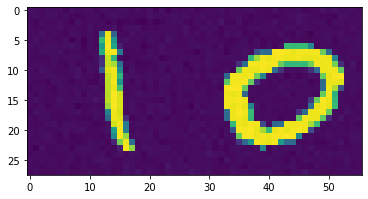

tensor(1) 50



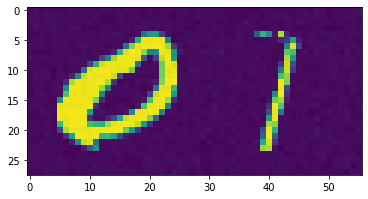

tensor(0) 51



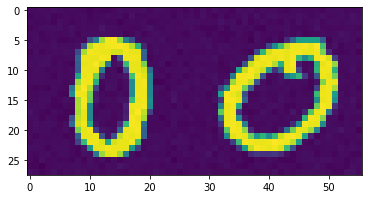

tensor(0) 52



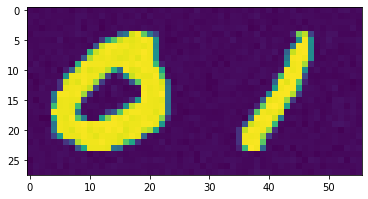

tensor(0) 53



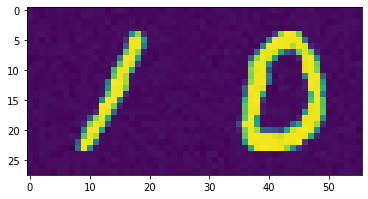

tensor(1) 54



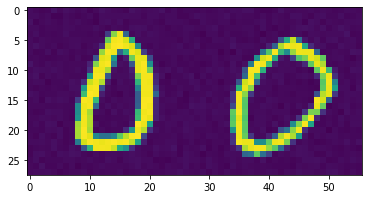

tensor(0) 55



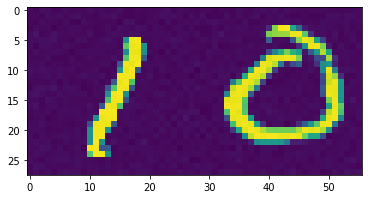

tensor(1) 56



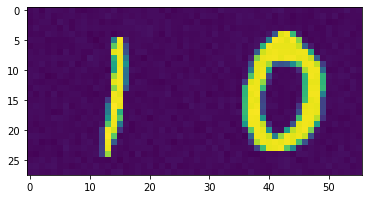

tensor(1) 57



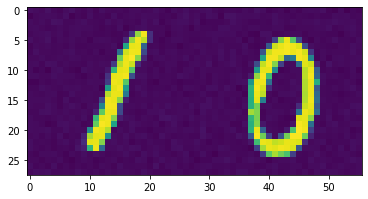

tensor(1) 58



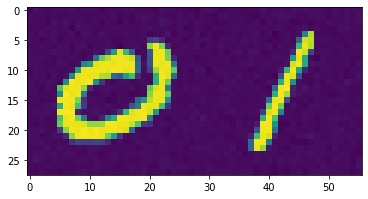

tensor(0) 59



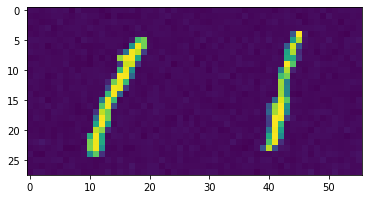

tensor(1) 60



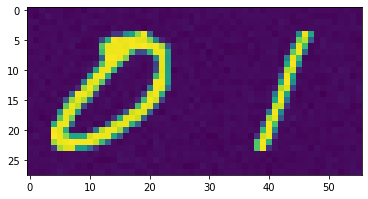

tensor(0) 61



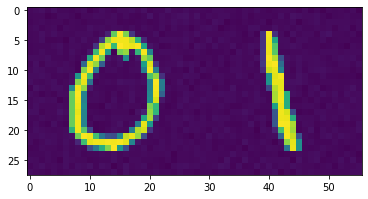

tensor(0) 62



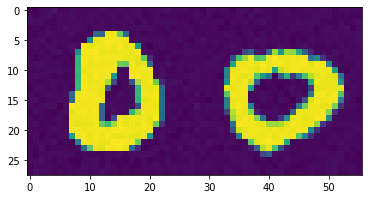

tensor(0) 63



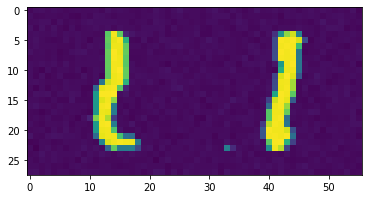

tensor(1) 64



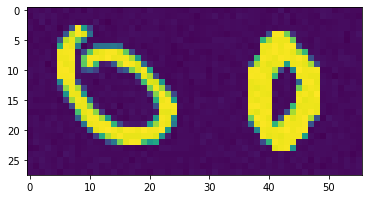

tensor(0) 65



KeyboardInterrupt: ignored

In [207]:
import matplotlib.pyplot as plt

Y_unlabeled = net(torch.Tensor(X_val))
y_u = torch.argmax(Y_unlabeled, axis=1)
for i in range(100):
    plt.imshow(X_val[i, 0])
    plt.show()
    print(y_u[i], i)
    #print(y_labeled[i], i)
    print("")

In [ ]:

print(y_pred.shape)
pred = y_u

pred = pred.numpy()
df = pd.DataFrame(pred)
df.to_csv("01_mnist_cc.csv", header=False, index=False)